In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/processed_data/merged_characteristics.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']


#create market data...
df['shares'] = df['Ever Enrolled Count']/df['DP03_0095E']

#add blp columns
df['prices'] = df['EHBPercentTotalPremium']
df['product_ids'] = df['IssuerId'].astype(str) +  df['County'].astype(str) 
df['market_ids'] = df['County']
df['firm_ids'] = df['IssuerId']

#demand_instrument0
MktIds = np.array(pd.get_dummies(df['IssuerId']))
MktIds2 = (MktIds.T).dot(MktIds)
dummies_proj = MktIds.dot( np.linalg.inv( MktIds2 ) ).dot( MktIds.T )
df['demand_instruments0'] = dummies_proj.dot(df['prices']) #average price across markets


#fix problematic columns =
df = df.rename(columns={'Average Monthly Advanced CSR Payment for Consumers with 94%':'csr_pay_94',
                  'Average Monthly Advanced CSR Payment for Consumers with 87%':'csr_pay_87',
                       'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94'})

#create mkt share data
blp_keys = ['market_ids', 'product_ids', 'firm_ids', 'shares', 'prices','demand_instruments0']

nonlinear_cols = ['csr_pay_94']#,'SBCHavingDiabetesCopayment','SBCHavingaBabyCoinsurance']
#['act_value','csr_pay_94','csr_pay_87','SBCHavingDiabetesCopayment','SBCHavingaBabyCoinsurance']

linear_cols = [ 'act_value', 'MetalLevel_Silver','MetalLevel_Platinum']#
#['CompositeRatingOffered_No','MetalLevel_Silver','MetalLevel_Platinum',
# 'BeginPrimaryCareCostSharingAfterNumberOfVisits' , 'csr_tot', 'csr_tot_94', 'PlanType_Indemnity']            
#'CSRVariationTypeBinary','DentalOnlyPlan_No','CompositeRatingOffered_No',

firm_cols =  linear_cols+ nonlinear_cols    
mkt_cols = [ 'DP05_0015PE' ,'DP05_0069PE']
#'DP05_0072PE', ,

blp_data = df[blp_keys+linear_cols+nonlinear_cols+mkt_cols+['DP03_0095E']]


#standardize the cols
for col in firm_cols:
    #this line is causing a warning?
    blp_data[col] = blp_data[col]/blp_data[col].var()

#zero shares are not okay?
blp_data = blp_data[blp_data['shares']!=0]

<ipython-input-2-cbbec7c7df87>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blp_data[col] = blp_data[col]/blp_data[col].var()


       Ever Enrolled Count    prices  MetalLevel_Silver        csr_tot  count
State                                                                        
NE              178.666667  1.000000           0.333333     289.466667     15
UT             3039.272727  0.979380           0.400000    2682.454545     11
VA              894.500000  0.652174           0.347826     901.500000      6
NC             2907.600000  1.000000           0.400000    2882.600000      5
FL           104536.250000  0.947717           0.300000  162676.500000      4
TX              130.666667  1.000000           0.333333     131.666667      3
WI              994.000000  0.995937           0.527778    1271.333333      3
MI              731.000000  0.000000           0.000000     669.000000      1
MO              607.000000  0.562500           0.250000     670.000000      1
MT              316.000000  1.000000           0.500000     377.000000      1


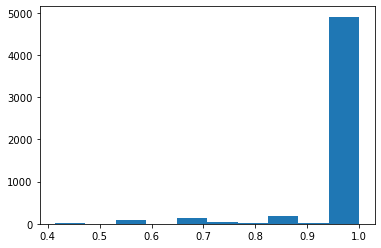

In [3]:
highest_shares = df[['shares','IssuerId','State','County Name',
          'Ever Enrolled Count','DP03_0095E','act_value','prices','MetalLevel_Silver',
    'csr_tot','csr_pay_94']].sort_values('shares',ascending=False).head(50)


highest_share_groupy = highest_shares.groupby('State')[['Ever Enrolled Count','prices','MetalLevel_Silver','csr_tot']].mean()
highest_share_groupy['count'] =highest_shares.groupby('State')['shares'].count()
highest_share_groupy = highest_share_groupy.sort_values('count',ascending=False)
print(highest_share_groupy)


plt.hist(df['prices'][df['prices']>=.1])
plt.show()

In [4]:
#split into training and test
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(blp_data, blp_data, test_size=test_size)


model = sm.Logit(X_train['shares'],
                 sm.add_constant(X_train[linear_cols+nonlinear_cols+mkt_cols+['prices']]))
model_fit = model.fit()
print(model_fit.summary())
pred_shares = model_fit.predict(
    sm.add_constant(X_test[linear_cols+nonlinear_cols+mkt_cols+['prices']]))

Optimization terminated successfully.
         Current function value: 0.015845
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 shares   No. Observations:                 3635
Model:                          Logit   Df Residuals:                     3627
Method:                           MLE   Df Model:                            7
Date:                Wed, 13 Apr 2022   Pseudo R-squ.:                     inf
Time:                        19:56:57   Log-Likelihood:                -57.596
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.1001      2.387     -1.718      0.086      -8.779       0.579
ac

/home/erichschulman/anaconda3/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


MSE 25594875.554320272


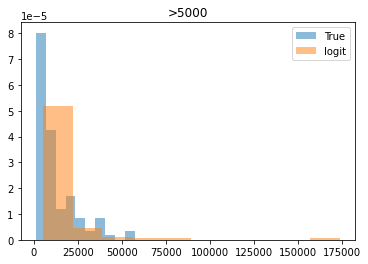

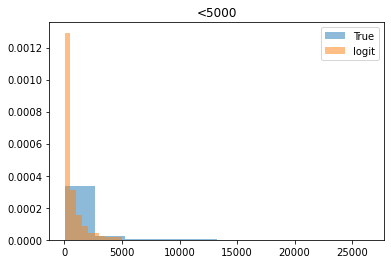

In [5]:
#evaluating model fit...
error = (X_test['shares']- pred_shares)*X_test['DP03_0095E']
print( 'MSE',(error**2).mean() )

blp_pred = pred_shares*X_test['DP03_0095E']
true_shares = X_test['shares']*X_test['DP03_0095E']

split = 5000
plt.title('>'+str(split))
plt.hist(blp_pred[true_shares >=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares >=split],label='logit',alpha = .5,density=True)
plt.legend()
plt.show()


plt.title('<'+str(split))
plt.hist(blp_pred[true_shares <=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares <=split],label='logit',alpha = .5,density=True)
plt.legend()
plt.show()

In [6]:
def report_error(X_test,pred_shares):
    pred_shares = np.array(pred_shares.copy())
    X_test = X_test.copy()
    X_test['error'] =  ((X_test['shares']- pred_shares)*X_test['DP03_0095E'])**2
    X_test['pred'] = pred_shares*X_test['DP03_0095E']
    result = X_test.merge(df, how='inner',left_index=True, right_index=True,suffixes=('_x',''))    
    result = result.sort_values('error',ascending=False).head(50) 
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby['count'] =result.groupby('State')['shares'].count()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

print(report_error(X_test,pred_shares))

               pred  Ever Enrolled Count      pred_var    enroll_var  count
State                                                                      
AZ     39139.229249          9897.000000           NaN           NaN      1
FL     35782.774876         47875.428571  14515.354592  62944.960886      7
MI     26282.257367          1172.500000    253.378123   1634.123771      2
TX     26183.642238         15997.375000  10764.853136  21948.985241      8
NV     23230.168307         47446.000000           NaN           NaN      1
UT      4496.311083         26153.000000           NaN           NaN      1
